---

_You are currently looking at **version 1.1** of this notebook. To download nb  and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this ques is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All the tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid many global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
#import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv',encoding='ISO-8859-1')
test = pd.read_csv('test.csv',encoding='ISO-8859-1')
train.head(1)


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0


In [3]:
train.drop(['balance_due',
 'collection_status',
 'compliance_detail',
 'payment_amount',
 'payment_date',
 'payment_status'],axis=1,inplace=True)


In [4]:
train.dropna(subset=["compliance"],inplace=True)
pd.set_option('display.max_columns', None)

In [5]:
train.head(1)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,NaN,0.0


In [6]:
train.drop(['grafitti_status'],axis=1,inplace=True)

In [7]:
test.drop('grafitti_status',axis=1,inplace=True)

In [8]:
y_train=train['compliance']
train.drop('compliance',axis=1,inplace=True)

In [9]:
test.set_index('ticket_id',inplace=True)
train.set_index('ticket_id',inplace=True)

In [10]:
ans=pd.concat([train,test],axis=0)

In [11]:
ans.head(1)

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0


In [12]:
lst=[]
for i in ans.columns:
    if(ans[i].dtype == "O"):
        lst.append((i,train[i].nunique()))
lst

[('agency_name', 5),
 ('inspector_name', 159),
 ('violator_name', 84656),
 ('violation_street_name', 1716),
 ('violation_zip_code', 0),
 ('mailing_address_str_number', 14090),
 ('mailing_address_str_name', 28440),
 ('city', 4093),
 ('state', 59),
 ('zip_code', 4622),
 ('non_us_str_code', 2),
 ('country', 5),
 ('ticket_issued_date', 68097),
 ('hearing_date', 5970),
 ('violation_code', 189),
 ('violation_description', 207),
 ('disposition', 4)]

In [13]:
drp=['violator_name','ticket_issued_date','mailing_address_str_name','mailing_address_str_number']

In [14]:
ans.drop(drp,axis=1,inplace=True)

In [15]:
nl=[]
for i in ans.columns:
    if(ans[i].dtype == "O"):
        nl.append((i,train[i].nunique()))

In [16]:
nl

[('agency_name', 5),
 ('inspector_name', 159),
 ('violation_street_name', 1716),
 ('violation_zip_code', 0),
 ('city', 4093),
 ('state', 59),
 ('zip_code', 4622),
 ('non_us_str_code', 2),
 ('country', 5),
 ('hearing_date', 5970),
 ('violation_code', 189),
 ('violation_description', 207),
 ('disposition', 4)]

In [17]:
# since 99% of values are 0
ans.drop('clean_up_cost',axis=1,inplace=True)

In [18]:
ans.head()
ans.drop('discount_amount',axis=1,inplace=True)

In [19]:
ans.drop('violation_zip_code',axis=1,inplace=True)

In [20]:
ans.drop('non_us_str_code',axis=1,inplace=True)

In [21]:
ans.drop('hearing_date',axis=1,inplace=True)

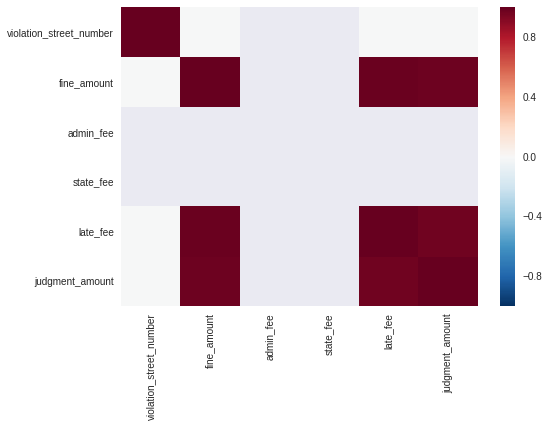

In [22]:
#sns.heatmap(ans.corr())
#plt.show()
ans['violation_description'].nunique()
ans.drop(['zip_code','violation_street_name','city','violation_description','violation_code'],axis=1,inplace=True)

In [23]:
ans.head(4)
df=pd.get_dummies(ans[['agency_name','country','disposition']],drop_first=True)

In [24]:
df.head(1)

,agency_name_Department of Public Works,agency_name_Detroit Police Department,agency_name_Health Department,agency_name_Neighborhood City Halls,country_Cana,country_Egyp,country_Germ,country_USA,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible - Compl/Adj by Default,disposition_Responsible - Compl/Adj by Determi,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination,disposition_Responsible by Dismissal
ticket_id,,,,,,,,,,,,,,,
22056,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [25]:
ans.drop(['inspector_name','state'],axis=1,inplace=True)

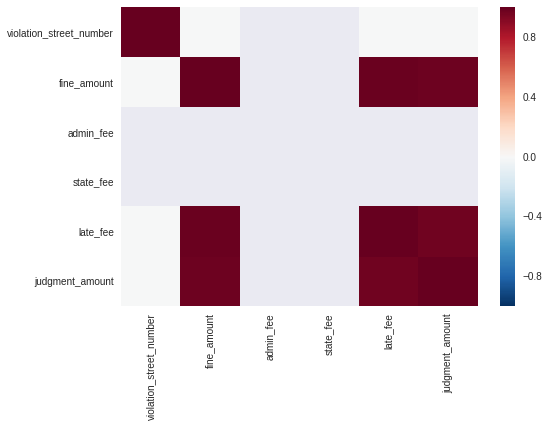

In [26]:
#sns.heatmap(ans.corr())
#plt.show()
# highly correlated
ans.drop(['judgment_amount','late_fee'],axis=1,inplace=True)

In [27]:
ans=pd.concat([df,ans],axis=1)

In [28]:
ans.drop(['agency_name','country','disposition'],axis=1,inplace=True)

In [29]:
ans.head(1)

,agency_name_Department of Public Works,agency_name_Detroit Police Department,agency_name_Health Department,agency_name_Neighborhood City Halls,country_Cana,country_Egyp,country_Germ,country_USA,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible - Compl/Adj by Default,disposition_Responsible - Compl/Adj by Determi,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination,disposition_Responsible by Dismissal,violation_street_number,fine_amount,admin_fee,state_fee
ticket_id,,,,,,,,,,,,,,,,,,,
22056,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2900.0,250.0,20.0,10.0


In [30]:
X_train=ans.iloc[:len(train),:]
X_test=ans.iloc[len(train):,:]

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
values = {'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 4, 5]}
clf=GradientBoostingClassifier(random_state=0)
final=GridSearchCV(clf,param_grid=values,scoring='roc_auc')
final.fit(X_train,y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [142]:
imp=(model.feature_importances_)
cols=X_train.columns
kll=[]
cnt=0
for i in cols:
    kll.append((i,imp[cnt]))
    cnt=cnt+1

In [126]:
kll
drpp=['agency_name_Neighborhood City Halls','country_Cana','country_Egyp','country_USA','disposition_Responsible - Compl/Adj by Default']
X_train.drop(drpp,axis=1,inplace=True)
X_test.drop(drpp,axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [135]:
kll
X_train.drop(['country_Germ','disposition_Responsible - Compl/Adj by Determi','disposition_Responsible by Dismissal','admin_fee','state_fee'],axis=1,inplace=True)
X_test.drop(['country_Germ','disposition_Responsible - Compl/Adj by Determi','disposition_Responsible by Dismissal','admin_fee','state_fee'],axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [143]:
kll

[('agency_name_Department of Public Works', 0.0052091107138090061),
 ('agency_name_Detroit Police Department', 0.0018300548014010668),
 ('agency_name_Health Department', 0.0022362339440575424),
 ('disposition_Responsible (Fine Waived) by Deter', 0.0099583417251588001),
 ('disposition_Responsible by Admission', 0.064762535979538544),
 ('disposition_Responsible by Default', 0.07061434110041595),
 ('disposition_Responsible by Determination', 0.022513520691817009),
 ('violation_street_number', 0.79580867577991865),
 ('fine_amount', 0.027067185263883263)]

In [33]:

#print('Grid best score (AUC): ', final.best_score_)
results=final.predict_proba(X_test)

Grid best score (AUC):  0.76594136656


In [35]:
results
finalres = pd.Series(results[:,1], index=X_test.index)

In [37]:
finalres.head()

ticket_id
284932    0.053426
285362    0.014954
285361    0.063845
285338    0.058422
285346    0.066105
dtype: float64

In [38]:


def blight_model():
    
    # Your code here
    
    return finalres

In [39]:
blight_model()

ticket_id
284932    0.053426
285362    0.014954
285361    0.063845
285338    0.058422
285346    0.066105
285345    0.058422
285347    0.060810
285342    0.421366
285530    0.016501
284989    0.022899
285344    0.060810
285343    0.016799
285340    0.016799
285341    0.060810
285349    0.066105
285348    0.058422
284991    0.022899
285532    0.024283
285406    0.020622
285001    0.022348
285006    0.015895
285405    0.014954
285337    0.021379
285496    0.088741
285497    0.085356
285378    0.014954
285589    0.021379
285585    0.052730
285501    0.088771
285581    0.014954
            ...   
376367    0.016981
376366    0.028948
376362    0.255610
376363    0.285999
376365    0.016981
376364    0.028948
376228    0.035426
376265    0.031322
376286    0.282528
376320    0.034091
376314    0.029157
376327    0.325678
376385    0.307977
376435    0.261617
376370    0.309898
376434    0.055307
376459    0.066811
376478    0.011091
376473    0.032740
376484    0.020699
376482    0.019093
37